In [19]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA

In [20]:
# Laste poll-of-polls data
url = "https://raw.githubusercontent.com/jensmorten/onesixtynine/main/data/pollofpolls_master.csv"
df = pd.read_csv(url)

In [21]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [22]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)
df.index.to_period('M').to_timestamp('M')

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31',
               ...
               '2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30',
               '2025-05-31', '2025-06-30', '2025-07-31', '2025-08-31',
               '2025-09-30', '2025-10-31'],
              dtype='datetime64[ns]', name='Mnd', length=214, freq='ME')

In [23]:
print(df.index[-5:])  # check last few dates

DatetimeIndex(['2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30',
               '2025-10-31'],
              dtype='datetime64[ns]', name='Mnd', freq=None)


In [24]:
df=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df.dropna(inplace=True)

In [25]:
cols = df.columns.tolist()
n = df.shape[1]
X = df.diff().dropna().values
pca = PCA(n_components=1).fit(X)
pc_loading = pca.components_.T.flatten()
# scale to sensible magnitude
pc_loading = pc_loading * 0.5

class PollingLLT_Factor_RW_Slope(MLEModel):
    """
    Multivariate LLT where:
      y_t = mu_t + eps_t
      mu_{t+1} = mu_t + beta_t + u_mu_t
      beta_{t+1} = beta_t + Lambda * f_t + u_beta_t
      f_{t+1} = f_t + u_f_t   (random walk: rho fixed = 1)

    State vector: [mu (n), beta (n), f (1)] => k_states = 2n + 1

    Params layout: [meas_var (n), psi_mu (n), psi_beta (n), Lambda (n), sigma_f (1)]
    (Note: rho is fixed to 1, not a parameter.)
    """
    def __init__(self, endog):
        k_endog = endog.shape[1]
        k_states = 2 * k_endog + 1
        super().__init__(endog, k_states=k_states, initialization='approximate_diffuse')

        # design: y_t = [I_n, 0, 0] * state
        Z = np.zeros((k_endog, k_states))
        Z[:, :k_endog] = np.eye(k_endog)
        self.ssm['design'] = Z

        # base transition (Lambda and rho handled in update)
        T = np.zeros((k_states, k_states))
        # mu_{t+1} = mu_t + beta_t + ...
        T[:k_endog, :k_endog] = np.eye(k_endog)
        T[:k_endog, k_endog:2*k_endog] = np.eye(k_endog)
        # beta_{t+1} = beta_t + Lambda * f_t  (Lambda inserted in update)
        T[k_endog:2*k_endog, k_endog:2*k_endog] = np.eye(k_endog)
        # f random walk: f_{t+1} = 1 * f_t  (set 1 in transition in update)
        T[2*k_endog, 2*k_endog] = 1.0
        self.ssm['transition'] = T

        self.ssm['selection'] = np.eye(k_states)
        self.k_endog = k_endog
        self.k_states = k_states

    @property
    def start_params(self):
        k = self.k_endog
        var = np.nanvar(np.asarray(self.endog), axis=0)
        # make meas var smaller so model trusts signal a bit more
        meas_init = np.maximum(var * 0.25, 1e-8)
        psi_mu_init = np.maximum(var * 0.01, 1e-8)
        psi_beta_init = np.maximum(var * 0.001, 1e-8)
        Lambda_init = np.zeros(k)
        sigma_f_init = 5   # larger initial factor variance
        return np.r_[meas_init, psi_mu_init, psi_beta_init, Lambda_init, sigma_f_init]

    def update(self, params, **kwargs):
        params = super().update(params, **kwargs)
        k = self.k_endog

        meas_var = params[:k]
        psi_mu = params[k:2*k]
        psi_beta = params[2*k:3*k]
        Lambda = params[3*k:4*k]
        sigma_f = params[4*k]

        # observation covariance
        self.ssm['obs_cov'] = np.diag(np.maximum(meas_var, 1e-12))

        # transition: inject Lambda into beta evolution (col index 2k)
        T = self.ssm['transition'].copy()
        T[k:2*k, 2*k] = Lambda   # factor affects slopes
        # f is random walk: ensure transition[2k,2k] == 1.0 (fixed)
        T[2*k, 2*k] = 1.0
        self.ssm['transition'] = T

        # state covariance Q: diag blocks
        Q = np.zeros((self.k_states, self.k_states))
        Q[:k, :k] = np.diag(np.maximum(psi_mu, 1e-12))
        Q[k:2*k, k:2*k] = np.diag(np.maximum(psi_beta, 1e-12))
        Q[2*k, 2*k] = max(sigma_f, 1e-12)
        self.ssm['state_cov'] = Q


In [26]:
# instantiate
mod = PollingLLT_Factor_RW_Slope(df)

# build start params and overwrite Lambda portion with PCA-based init
start = mod.start_params.copy()
k = mod.k_endog
start[3*k:4*k] = pc_loading * 0.6   # scale a bit
# lower measurement noise a bit
start[:k] = np.maximum(start[:k] * 0.5, 1e-8)
# raise sigma_f
start[4*k] = max(start[4*k], 0.8)

# fit with robust optimizer
res = mod.fit(start_params=start, disp=True, method='powell', maxiter=800)
print("Converged:", res.mle_retvals.get('converged', False))
print(res.summary())


C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 10.238268
         Iterations: 7
         Function evaluations: 3354


C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_17608\281318638.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  T[k:2*k, 2*k] = Lambda   # factor affects slopes
C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_17608\281318638.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[:k, :k] = np.diag(np.maximum(psi_mu, 1e-12))
C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_17608\281318638.py:82: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[k:2*k, k:2*k] = np.diag(np.maximum(psi_beta, 1e-12))
C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_17608\281318638.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[2*k, 2*k] = max(sigma_f, 1e-12)


Converged: True
                                                        Statespace Model Results                                                        
Dep. Variable:     ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt', 'Andre']   No. Observations:                  214
Model:                                                               PollingLLT_Factor_RW_Slope   Log Likelihood               -2190.989
Date:                                                                          Tue, 25 Nov 2025   AIC                           4463.979
Time:                                                                                  22:21:23   BIC                           4601.984
Sample:                                                                              01-31-2008   HQIC                          4519.745
                                                                                   - 10-31-2025                                         
Covariance Type:         

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3015: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


In [27]:
# extract smoothed states & forecast
smoothed = res.smoothed_state.T
mu = smoothed[:, :n]
beta = smoothed[:, n:2*n]
f_series = smoothed[:, 2*n]

mu_df = pd.DataFrame(mu, index=df.index, columns=cols)
beta_df = pd.DataFrame(beta, index=df.index, columns=[c + "_slope" for c in cols])
factor_df = pd.DataFrame(f_series, index=df.index, columns=['factor1'])

n_months = 12
pred = res.get_forecast(steps=n_months)
pred_mean = pred.predicted_mean
pred_var = pred.var_pred_mean
pred_std = np.sqrt(np.diagonal(pred_var, axis1=1, axis2=2))

forecast_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1), periods=n_months, freq='M')
forecast_df = pd.DataFrame(pred_mean, index=forecast_index, columns=cols)
forecast_lower_df = pd.DataFrame(pred_mean - 1.96*pred_std, index=forecast_index, columns=cols)
forecast_upper_df = pd.DataFrame(pred_mean + 1.96*pred_std, index=forecast_index, columns=cols)

# quick diagnostics
print("sigma_f (f variance):", res.params[4*k])
print("Lambda (first few):", res.params[3*k:3*k+min(10,k)])
print("Last factor values (tail):\n", factor_df.tail())

sigma_f (f variance): 0.00287127350425495
Lambda (first few): param.30    0.034159
param.31   -0.034950
param.32    0.023453
param.33   -0.012177
param.34   -0.005473
param.35    0.003490
param.36   -0.002595
param.37    0.004224
param.38   -0.001902
param.39   -0.003583
dtype: float64
Last factor values (tail):
              factor1
Mnd                 
2025-06-30  0.586213
2025-07-31  0.586397
2025-08-31  0.586367
2025-09-30  0.586367
2025-10-31  0.586367


C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_17608\125043484.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(df.index[-1] + pd.offsets.MonthEnd(1), periods=n_months, freq='M')
C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_17608\125043484.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("sigma_f (f variance):", res.params[4*k])


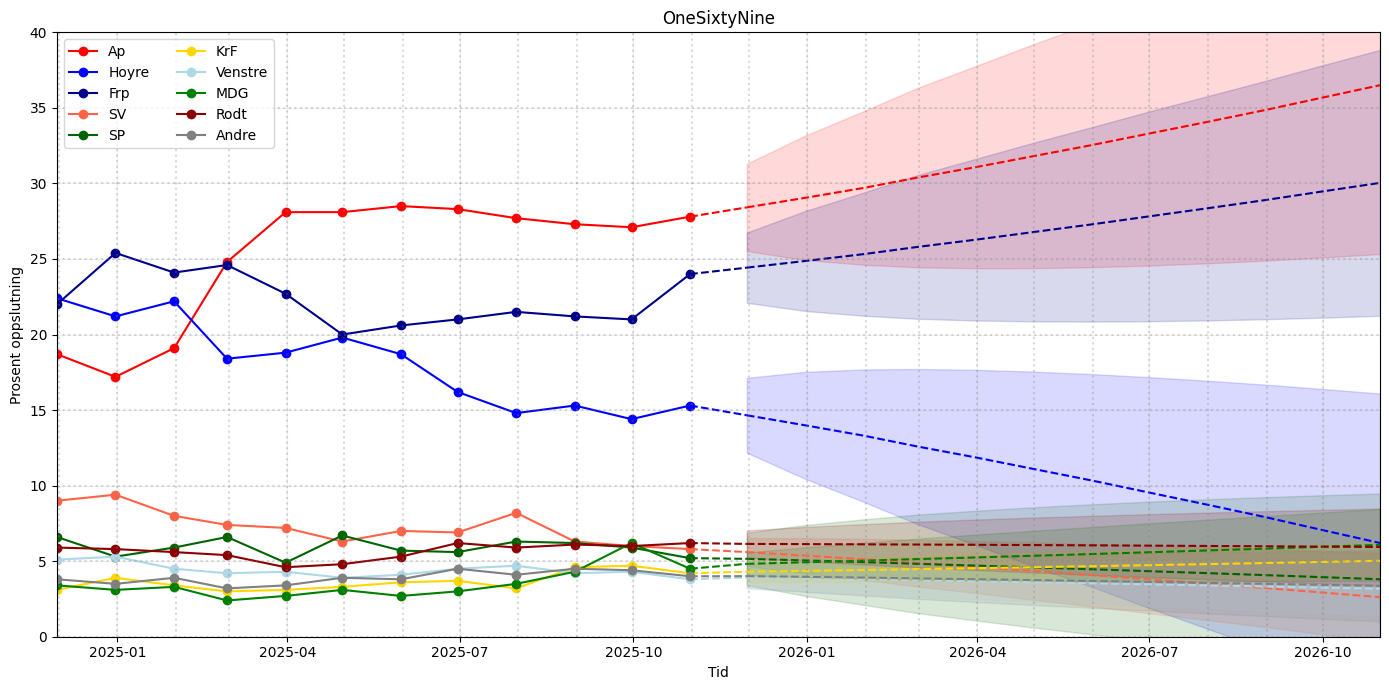

In [28]:
# --- Define colors for consistency ---
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}


# --- Plot ---
plt.figure(figsize=(14, 7))

months_back = 12
df_recent = df.iloc[-months_back:]  # last 12 months actual

for party, color in colors.items():

    # Actual observed data
    plt.plot(
        df_recent.index,
        df_recent[party],
        marker="o",
        color=color,
        label=f"{party}"
    )

    # Forecast line (bootstrap mean)
    plt.plot(
        forecast_df.index,
        forecast_df[party],
        linestyle="dashed",
        color=color
    )

    # Connect last actual point to first forecast
    plt.plot(
        [df_recent.index[-1], forecast_df.index[0]],
        [df_recent[party].iloc[-1], forecast_df[party].iloc[0]],
        linestyle="dashed",
        color=color
    )

    # Confidence interval (bootstrap)
    plt.fill_between(
        forecast_df.index,
        forecast_lower_df[party],
        forecast_upper_df[party],
        color=color,
        alpha=0.15
    )

# --- Vertical monthly guides ---
dates = pd.date_range(start=df_recent.index[0], end=forecast_df.index[-1], freq="MS")
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.3)

# --- Horizontal percentage lines ---
for percent in range(0, 45, 5):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.3)

# --- Final formatting ---
plt.xlim(df_recent.index[0], forecast_df.index[-1])
plt.ylim(0, 40)
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine")
plt.legend(loc="upper left", ncol=2)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()
